In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import os

## Data read

In [2]:
DATA_PATH = "./data/used_cars.csv"

In [3]:
data = pd.read_csv(DATA_PATH)

## Overview

https://www.kaggle.com/datasets/taeefnajib/used-car-price-prediction-dataset

**Brand & Model**: Identify the brand or company name along with the specific model of each vehicle.

**Model Year**: Discover the manufacturing year of the vehicles, crucial for assessing depreciation and technology advancements.

**Mileage**: Obtain the mileage of each vehicle, a key indicator of wear and tear and potential maintenance requirements.

**Fuel Type**: Learn about the type of fuel the vehicles run on, whether it's gasoline, diesel, electric, or hybrid.

**Engine Type**: Understand the engine specifications, shedding light on performance and efficiency.

**Transmission**: Determine the transmission type, whether automatic, manual, or another variant.

**Exterior & Interior Colors**: Explore the aesthetic aspects of the vehicles, including exterior and interior color options.

**Accident History**: Discover whether a vehicle has a prior history of accidents or damage, crucial for informed decision-making.

**Clean Title**: Evaluate the availability of a clean title, which can impact the vehicle's resale value and legal status.

**Price**: Access the listed prices for each vehicle, aiding in price comparison and budgeting.

In [4]:
data.head(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"
5,Acura,ILX 2.4L,2016,"136,397 mi.",Gasoline,2.4 Liter,F,Silver,Ebony.,None reported,NaN,"$14,798"
6,Audi,S3 2.0T Premium Plus,2017,"84,000 mi.",Gasoline,292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,Blue,Black,None reported,Yes,"$31,000"
7,BMW,740 iL,2001,"242,000 mi.",Gasoline,282.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,A/T,Green,Green,None reported,Yes,"$7,300"
8,Lexus,RC 350 F Sport,2021,"23,436 mi.",Gasoline,311.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,None reported,Yes,"$41,927"
9,Tesla,Model X Long Range Plus,2020,"34,000 mi.",NaN,534.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes,"$69,950"


In [5]:
data.isnull().sum()

brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64

In [6]:
data.duplicated().sum()

0

In [7]:
data.nunique()

brand             57
model           1898
model_year        34
milage          2818
fuel_type          7
engine          1146
transmission      62
ext_col          319
int_col          156
accident           2
clean_title        1
price           1569
dtype: int64

In [8]:
print("Brand unique: ", data.brand.unique())
print("Clean title unique: ", data.clean_title.unique())
print("Accident unique: ", data.accident.unique())
print("transmission unique: ", data.transmission.unique())
print("fuel_type unique: ", data.fuel_type.unique())

Brand unique:  ['Ford' 'Hyundai' 'Lexus' 'INFINITI' 'Audi' 'Acura' 'BMW' 'Tesla' 'Land'
 'Aston' 'Toyota' 'Lincoln' 'Jaguar' 'Mercedes-Benz' 'Dodge' 'Nissan'
 'Genesis' 'Chevrolet' 'Kia' 'Jeep' 'Bentley' 'Honda' 'Lucid' 'MINI'
 'Porsche' 'Hummer' 'Chrysler' 'Volvo' 'Cadillac' 'Lamborghini' 'Maserati'
 'Volkswagen' 'Subaru' 'Rivian' 'GMC' 'RAM' 'Alfa' 'Ferrari' 'Scion'
 'Mitsubishi' 'Mazda' 'Saturn' 'Bugatti' 'Polestar' 'Rolls-Royce'
 'McLaren' 'Buick' 'Lotus' 'Pontiac' 'FIAT' 'Karma' 'Saab' 'Mercury'
 'Plymouth' 'smart' 'Maybach' 'Suzuki']
Clean title unique:  ['Yes' nan]
Accident unique:  ['At least 1 accident or damage reported' 'None reported' nan]
transmission unique:  ['6-Speed A/T' '8-Speed Automatic' 'Automatic' '7-Speed A/T' 'F' 'A/T'
 '8-Speed A/T' 'Transmission w/Dual Shift Mode' '9-Speed Automatic'
 '6-Speed M/T' '10-Speed A/T' '9-Speed A/T' '5-Speed A/T' '1-Speed A/T'
 'Automatic CVT' '7-Speed Automatic with Auto-Shift' 'CVT-F' 'M/T'
 '6-Speed Automatic with Auto-Shift' '10

## Initial cleaning 

### String cleaning

In [9]:
data.brand = data.brand.str.lower()
data.model = data.model.str.lower()
data.fuel_type = data.fuel_type.str.lower()
data.engine = data.engine.str.lower()
data.transmission = data.transmission.str.lower()
data.ext_col = data.ext_col.str.lower()
data.int_col = data.int_col.str.lower()
data.accident = data.accident.str.lower()
data.clean_title = data.clean_title.str.lower()

In [10]:
data.milage = data.milage.str.replace(',', '').str.extract('(\d+)').astype(float)
data.price = data.price.str.replace(',', '').str.extract('(\d+)').astype(float)

In [11]:
print("Brand unique: ", data.brand.unique())

Brand unique:  ['ford' 'hyundai' 'lexus' 'infiniti' 'audi' 'acura' 'bmw' 'tesla' 'land'
 'aston' 'toyota' 'lincoln' 'jaguar' 'mercedes-benz' 'dodge' 'nissan'
 'genesis' 'chevrolet' 'kia' 'jeep' 'bentley' 'honda' 'lucid' 'mini'
 'porsche' 'hummer' 'chrysler' 'volvo' 'cadillac' 'lamborghini' 'maserati'
 'volkswagen' 'subaru' 'rivian' 'gmc' 'ram' 'alfa' 'ferrari' 'scion'
 'mitsubishi' 'mazda' 'saturn' 'bugatti' 'polestar' 'rolls-royce'
 'mclaren' 'buick' 'lotus' 'pontiac' 'fiat' 'karma' 'saab' 'mercury'
 'plymouth' 'smart' 'maybach' 'suzuki']


### Extracting features

In [12]:
def categorize_transmission(x):
    x = x.lower()
    if 'manual' in x or 'm/t' in x or '6 speed mt' in x or 'manual, 6-spd' in x:
        return 'manual'
    elif 'automatic' in x or 'a/t' in x or 'cvt' in x or 'auto' in x:
        return 'automatic'
    elif 'dual-clutch' in x or 'dct' in x:
        return 'dual_clutch'
    else:
        return 'automatic' 

In [13]:
data["transmission_category"] = data['transmission'].apply(categorize_transmission)

In [14]:
def enhance_dataframe_with_engine_info(df):
    hp_pattern = re.compile(r'(\d+\.?\d*)\s*hp', re.IGNORECASE)
    volume_pattern = re.compile(r'(\d+\.?\d*)\s*l', re.IGNORECASE)
    cylinder_pattern = re.compile(r'(\d+)\s*cylinder', re.IGNORECASE)
    v_cylinder_pattern = re.compile(r'V(\d+)', re.IGNORECASE)
    
    horsepower = []
    engine_volume_l = []
    cylinders = []
    
    for engine_str in df['engine']:
        hp_match = hp_pattern.search(engine_str)
        volume_match = volume_pattern.search(engine_str)
        cylinder_match = cylinder_pattern.search(engine_str)
        v_cylinder_match = v_cylinder_pattern.search(engine_str)
        
        if hp_match:
            horsepower.append(float(hp_match.group(1)))
        else:
            horsepower.append(None)
        
        if volume_match:
            engine_volume_l.append(float(volume_match.group(1)))
        else:
            engine_volume_l.append(None)
        
        if cylinder_match:
            cylinders.append(int(cylinder_match.group(1)))
        elif v_cylinder_match:
            cylinders.append(int(v_cylinder_match.group(1)))
        else:
            cylinders.append(None)

    df['horsepower'] = horsepower
    df['engine_volume_l'] = engine_volume_l
    df['cylinders'] = cylinders
    
    return df

In [15]:
data = enhance_dataframe_with_engine_info(data)

In [16]:
data.accident = data.accident.map({"at least 1 accident or damage reported" : True, "none reported": False})
data.clean_title = data.clean_title.fillna("no")
data.clean_title = data.clean_title.map({"yes" : True, "no": False})

In [17]:
# Budget Brands (Under $25,000)
budget_brands = [
    "suzuki", "smart", "scion", "saab", "saturn", "pontiac", "fiat", "mitsubishi", "mercury"
]

# Mass Market Brands ($25,000 - $45,000)
mass_market_brands = [
    "hyundai", "kia", "honda", "toyota", "nissan", "mazda", "subaru", "volkswagen",
    "jeep", "dodge", "chevrolet", "chrysler", "ford", "buick", "gmc", "plymouth"
]

# Premium Brands ($45,000 - $75,000)
premium_brands = [
    "acura", "infiniti", "bmw", "audi", "mercedes-benz", "volvo", "cadillac", "lexus",
    "alfa", "genesis", "land rover", "jaguar", "lincoln", "tesla", "mini", "ram", "polestar", "karma", "land"
]

# Luxury Brands ($75,000 - $150,000)
luxury_brands = [
    "porsche", "lotus", "maserati", "hummer", "aston"
]

# Super Luxury Brands ($150,000 and above)
super_luxury_brands = [
    "aston martin", "bentley", "ferrari", "lamborghini", "mclaren", "rolls-royce",
    "bugatti", "lucid", "rivian", "maybach"
]

mean_price_by_brand = data.groupby("brand")['price'].mean()
sorted_mean_price_by_brand = mean_price_by_brand.sort_values(ascending=False)  # Use ascending=True for ascending order
print(sorted_mean_price_by_brand)

price_groups = {}
for brand in data['brand'].unique():
    if brand in budget_brands:
        price_groups[brand] = 0
    elif brand in mass_market_brands:
        price_groups[brand] = 1
    elif brand in premium_brands:
        price_groups[brand] = 2
    elif brand in luxury_brands:
        price_groups[brand] = 3
    elif brand in super_luxury_brands:
        price_groups[brand] = 4
    else:
        print(brand)
        price_groups[brand] = 'unknown'

data['price_group'] = data['brand'].map(price_groups)
data = data[data["price_group"] < 3]

brand
bugatti          1.950995e+06
rolls-royce      3.709927e+05
lamborghini      2.912338e+05
ferrari          2.437907e+05
mclaren          2.134575e+05
maserati         1.405825e+05
bentley          1.375535e+05
aston            1.151996e+05
lucid            1.019663e+05
rivian           9.313818e+04
porsche          8.875130e+04
maybach          6.425000e+04
land             5.576406e+04
lotus            5.481250e+04
karma            5.325000e+04
mercedes-benz    5.207577e+04
tesla            4.843947e+04
genesis          4.327990e+04
ram              4.302916e+04
cadillac         4.167073e+04
bmw              4.107231e+04
audi             3.990743e+04
alfa             3.768605e+04
gmc              3.752568e+04
chevrolet        3.672274e+04
ford             3.624088e+04
polestar         3.599900e+04
lexus            3.566852e+04
dodge            3.450054e+04
jaguar           3.236272e+04
jeep             3.109979e+04
toyota           3.002600e+04
plymouth         2.850000e+04
linc

### Cleaning features 

In [18]:
data.isnull().sum()

brand                      0
model                      0
model_year                 0
milage                     0
fuel_type                141
engine                     0
transmission               0
ext_col                    0
int_col                    0
accident                  89
clean_title                0
price                      0
transmission_category      0
horsepower               725
engine_volume_l          184
cylinders                550
price_group                0
dtype: int64

In [19]:
def fill_missing_horsepower(df):

    median_hp = df['horsepower'].median()
    median_volume = df['engine_volume_l'].median()
    hp_per_liter = median_hp / median_volume if median_volume else 0
    
    for index, row in df.iterrows():
        if pd.isna(row['horsepower']):
            if not pd.isna(row['engine_volume_l']):
                df.at[index, 'horsepower'] = row['engine_volume_l'] * hp_per_liter
            else:
                brand_median = df[df['brand'] == row['brand']]['horsepower'].median()
                if pd.notna(brand_median):
                    df.at[index, 'horsepower'] = brand_median
                else:
                    df.at[index, 'horsepower'] = median_hp
        

    return df

def fill_missing_fuel_types(df):
    most_common_fuel_by_brand = df.groupby('brand')['fuel_type'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    def fill_fuel_type(row):
        if pd.isnull(row['fuel_type']) or row['fuel_type'] == '–' :
            return most_common_fuel_by_brand[row['brand']]
        else:
            return row['fuel_type']
            
    df.fuel_type = df.apply(fill_fuel_type, axis=1)
    df.fuel_type = df.fuel_type.replace("not supported", "hydrogen")
    df.fuel_type = df.fuel_type.fillna("electric")
    return df


In [20]:
data = fill_missing_horsepower(data)
data = fill_missing_fuel_types(data)

/home/mkapala/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [21]:
data.accident = data.accident.fillna(data.accident.mode()[0])

/tmp/ipykernel_19977/34994821.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.accident = data.accident.fillna(data.accident.mode()[0])


In [22]:
data.isnull().sum()

brand                      0
model                      0
model_year                 0
milage                     0
fuel_type                  0
engine                     0
transmission               0
ext_col                    0
int_col                    0
accident                   0
clean_title                0
price                      0
transmission_category      0
horsepower                 0
engine_volume_l          184
cylinders                550
price_group                0
dtype: int64

## Data analysis

In [23]:
data.sample(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,transmission_category,horsepower,engine_volume_l,cylinders,price_group
1665,mitsubishi,lancer gts,2009,185963.0,gasoline,168.0hp 2.4l 4 cylinder engine gasoline fuel,cvt transmission,orange,gray,True,True,5100.0,automatic,168.000000,2.4,4.0,0
2661,ford,mustang gt premium,2019,10400.0,gasoline,460.0hp 5.0l 8 cylinder engine gasoline fuel,10-speed a/t,red,gray,False,True,40000.0,automatic,460.000000,5.0,8.0,1
3735,jeep,wrangler unlimited sahara,2019,57000.0,gasoline,285.0hp 3.6l v6 cylinder engine gasoline fuel,8-speed a/t,gray,black,False,True,39900.0,automatic,285.000000,3.6,6.0,1
1949,chevrolet,tahoe ltz,2015,123500.0,gasoline,355.0hp 5.3l 8 cylinder engine gasoline fuel,6-speed a/t,white,brown,False,True,25650.0,automatic,355.000000,5.3,8.0,1
2285,land,rover range rover sport 3.0l supercharged hse,2017,95212.0,gasoline,340.0hp 3.0l v6 cylinder engine gasoline fuel,8-speed a/t,brown,beige,False,True,31599.0,automatic,340.000000,3.0,6.0,2
1230,tesla,model y long range,2021,14642.0,electric,425.0hp electric motor electric fuel system,a/t,red,black,False,True,48500.0,automatic,425.000000,NaN,NaN,2
2482,toyota,sequoia sr5,2007,136000.0,gasoline,273.0hp 4.7l 8 cylinder engine gasoline fuel,a/t,black,beige,False,True,12500.0,automatic,273.000000,4.7,8.0,1
2767,chevrolet,suburban premier,2021,51890.0,gasoline,5.3l v8 16v gdi ohv,10-speed automatic,shadow gray metallic,jet black,False,True,59980.0,automatic,460.342857,5.3,8.0,1
803,ford,ranger sport supercab,2009,166200.0,gasoline,207.0hp 4.0l v6 cylinder engine gasoline fuel,a/t,blue,gray,True,True,6999.0,automatic,207.000000,4.0,6.0,1
1491,ford,focus rs base,2016,14900.0,gasoline,350.0hp 2.3l 4 cylinder engine gasoline fuel,6-speed m/t,blue,black,False,True,39000.0,manual,350.000000,2.3,4.0,1


In [24]:
data.describe()

,model_year,milage,price,horsepower,engine_volume_l,cylinders,price_group
count,3635.000000,3635.000000,3635.000000,3635.000000,3451.000000,3085.000000,3635.000000
mean,2015.546080,67457.735626,35796.972490,317.406347,3.650232,6.238898,1.480055
std,6.087986,52827.661726,30903.508479,114.682046,1.432277,1.575482,0.530652
min,1974.000000,100.000000,2000.000000,70.000000,0.650000,3.000000,0.000000
25%,2012.000000,25095.500000,16000.000000,235.000000,2.500000,6.000000,1.000000
50%,2017.000000,56000.000000,29500.000000,304.000000,3.500000,6.000000,1.000000
75%,2020.000000,97445.500000,45999.000000,385.000000,4.600000,8.000000,2.000000
max,2024.000000,405000.000000,489995.000000,1020.000000,8.400000,12.000000,2.000000


/tmp/ipykernel_19977/3787292208.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.hist(ax = ax)


array([[<AxesSubplot: title={'center': 'model_year'}>,
        <AxesSubplot: title={'center': 'milage'}>,
        <AxesSubplot: title={'center': 'price'}>],
       [<AxesSubplot: title={'center': 'horsepower'}>,
        <AxesSubplot: title={'center': 'engine_volume_l'}>,
        <AxesSubplot: title={'center': 'cylinders'}>],
       [<AxesSubplot: title={'center': 'price_group'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

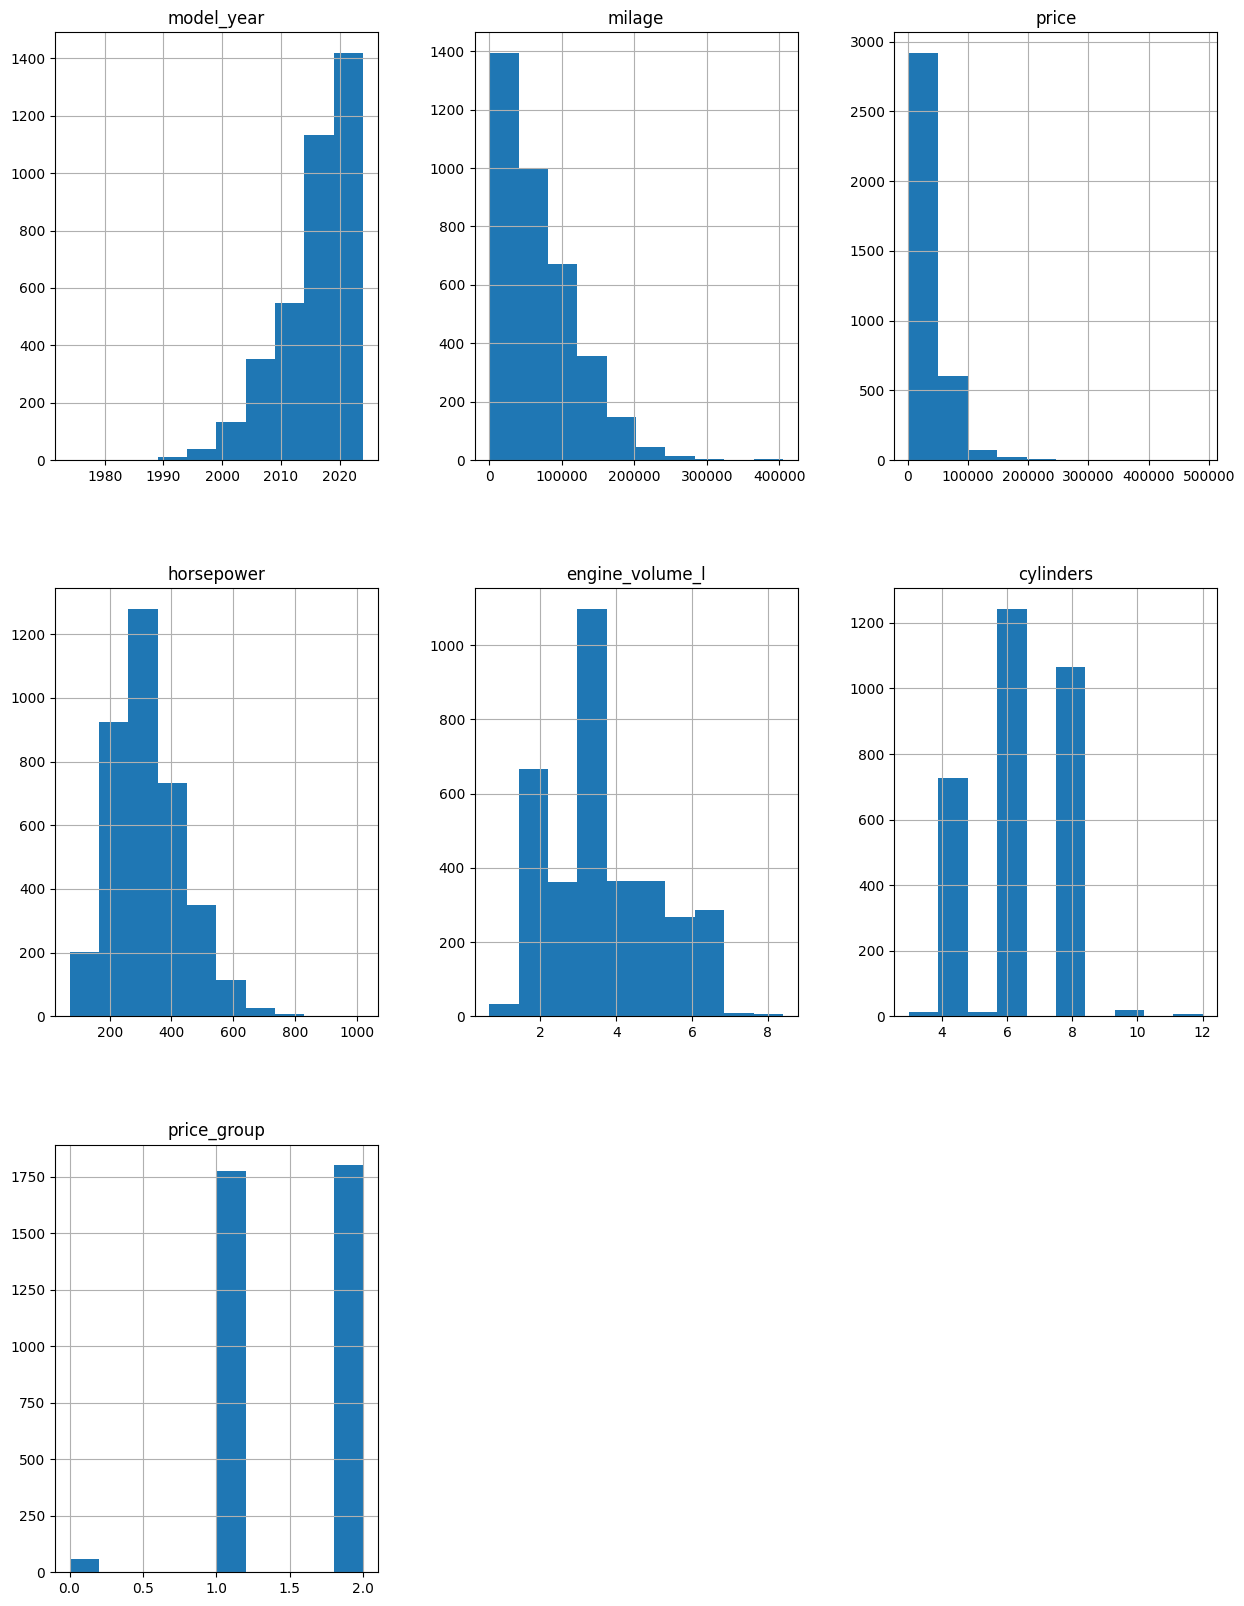

In [25]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data.hist(ax = ax)

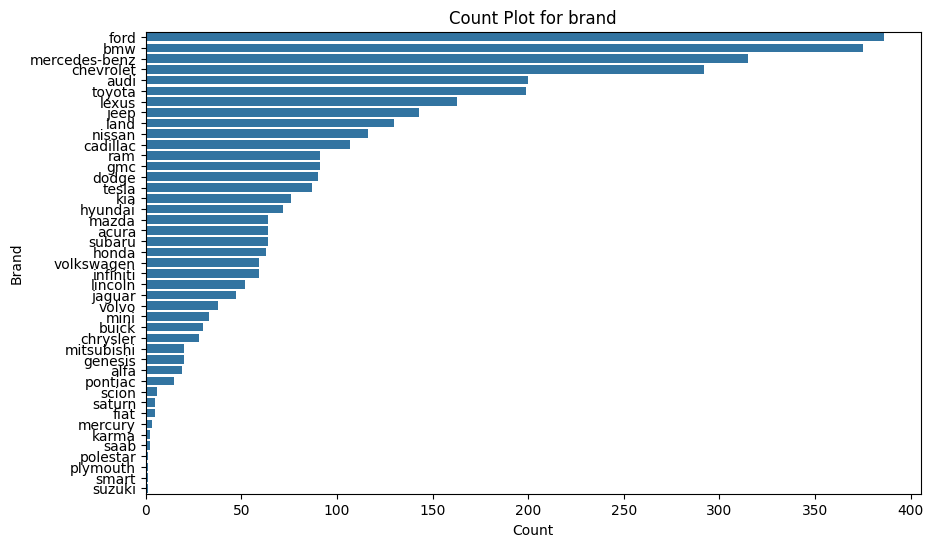

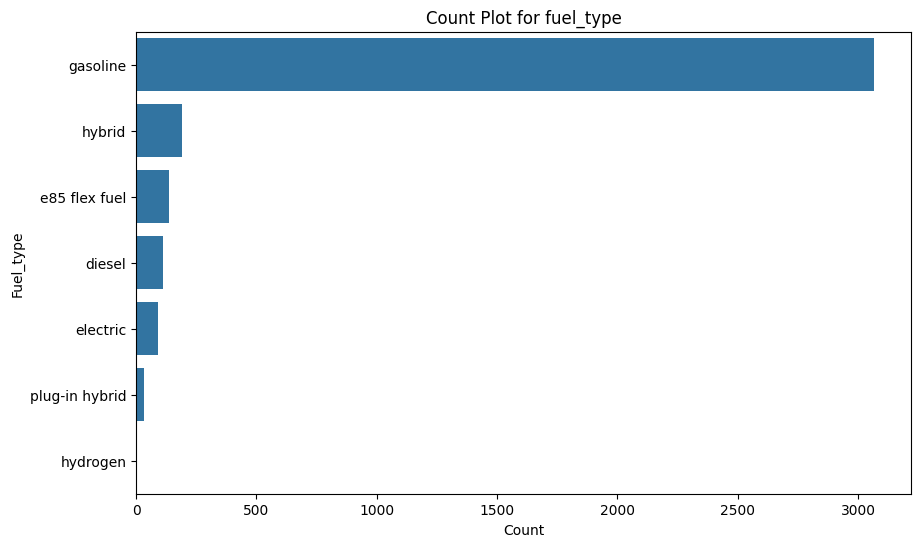

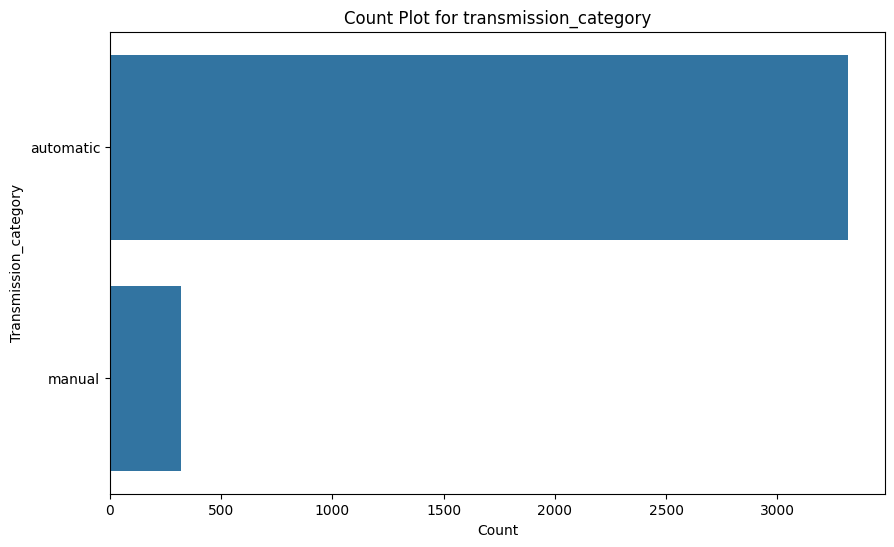

In [26]:
categorical_columns = ['brand', 'fuel_type', 'transmission_category']

for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=column, data=data, order = data[column].value_counts().index)
    plt.title(f'Count Plot for {column}')
    plt.xlabel('Count')
    plt.ylabel(column.capitalize())
    plt.show()

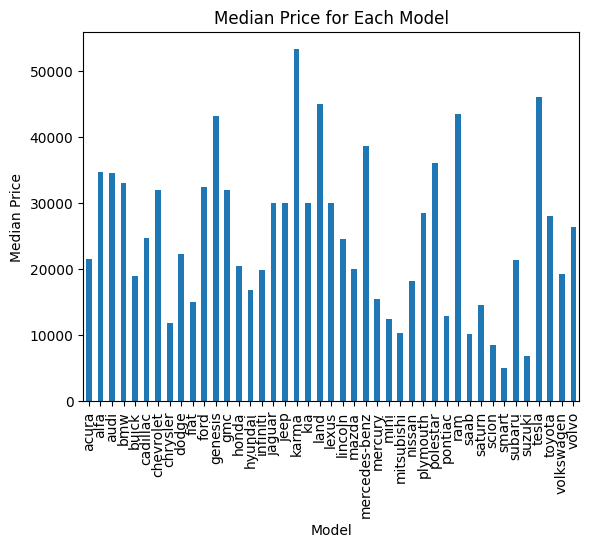

In [27]:
median_prices = data.groupby('brand')['price'].median()

median_prices.plot(kind='bar')
plt.xlabel('Model')
plt.ylabel('Median Price')
plt.title('Median Price for Each Model')
plt.show()

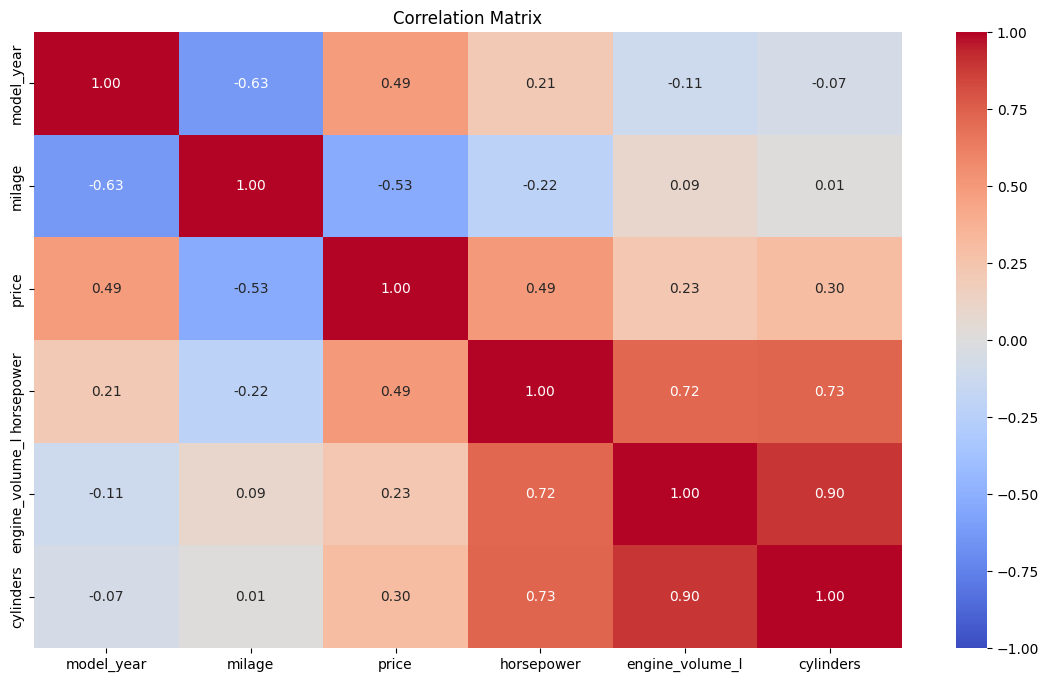

In [28]:
numerical_features = ["model_year", "milage", "price", "horsepower", "engine_volume_l", "cylinders"]
correlation_matrix = data[numerical_features].corr()
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

## clean outliers

In [29]:
# data = data.drop(data[data[] == 'bugatti'].index)

## Feature selection

In [30]:
X = data[numerical_features].drop(columns=["price"])
y = data["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

feature_importance_df.head(20)

,Feature,Importance
1,milage,0.403445
2,horsepower,0.253764
0,model_year,0.191468
3,engine_volume_l,0.125152
4,cylinders,0.026171


In [31]:
data.sample(2)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,transmission_category,horsepower,engine_volume_l,cylinders,price_group
62,mercedes-benz,glk-class glk 350,2014,186000.0,gasoline,302.0hp 3.5l v6 cylinder engine gasoline fuel,a/t,black,beige,True,True,10000.0,automatic,302.0,3.5,6.0,2
1064,kia,optima lx,2019,62660.0,gasoline,185.0hp 2.4l 4 cylinder engine gasoline fuel,a/t,white,black,False,True,16500.0,automatic,185.0,2.4,4.0,1


In [32]:
data = data.drop(["model", "model_year", "engine", "transmission", "ext_col", "int_col", "engine_volume_l", "cylinders"], axis=1)

In [33]:
data.sample(2)

,brand,milage,fuel_type,accident,clean_title,price,transmission_category,horsepower,price_group
3634,land,59500.0,e85 flex fuel,False,True,33800.0,automatic,340.000000,2
1742,cadillac,44692.0,gasoline,False,False,32368.0,automatic,312.685714,2


## Data standarization

In [34]:
scaler_standard = StandardScaler()
data[["milage", "horsepower"]] = scaler_standard.fit_transform(data[["milage", "horsepower"]])

## Data encoding 

In [35]:
data = data.drop("brand", axis=1)
data = pd.get_dummies(data)

In [36]:
data.sample(10)

,milage,accident,clean_title,price,horsepower,price_group,fuel_type_diesel,fuel_type_e85 flex fuel,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_hydrogen,fuel_type_plug-in hybrid,transmission_category_automatic,transmission_category_manual
983,-0.917406,False,False,74900.0,0.676691,2,False,False,False,False,True,False,False,True,False
1304,-1.069809,False,True,60995.0,0.938320,2,False,False,False,True,False,False,False,False,True
663,-0.292647,True,True,53722.0,0.502272,1,False,False,False,True,False,False,False,True,False
2916,-0.835998,False,True,67500.0,1.069134,1,False,False,False,True,False,False,False,True,False
2902,0.067062,False,True,22000.0,-0.282614,1,False,False,False,True,False,False,False,True,False
1665,2.243551,True,True,5100.0,-1.302967,0,False,False,False,True,False,False,False,True,False
1206,1.914834,False,True,29500.0,0.894715,2,False,False,False,True,False,False,False,True,False
166,0.010266,False,True,36499.0,-0.605290,2,False,False,False,True,False,False,False,True,False
1813,0.388908,True,True,57000.0,1.417973,1,False,False,False,True,False,False,False,True,False
1650,0.614484,True,True,26500.0,0.197038,2,False,False,False,True,False,False,False,True,False


In [37]:
data.columns

Index(['milage', 'accident', 'clean_title', 'price', 'horsepower',
       'price_group', 'fuel_type_diesel', 'fuel_type_e85 flex fuel',
       'fuel_type_electric', 'fuel_type_gasoline', 'fuel_type_hybrid',
       'fuel_type_hydrogen', 'fuel_type_plug-in hybrid',
       'transmission_category_automatic', 'transmission_category_manual'],
      dtype='object')

In [38]:
data.to_csv("./data/cleaned_car_data.csv")

In [39]:
features = data.drop(["price"], axis=1)
target = data["price"]